# Summary



# Table of Contents

1. [Import Packages](#import)
2. [Load Data](#load)
   1. [Load ASOS CID data](#CID)
   2. [Set correct data types](#types)
   3. [Handle duplicate and missing data](#missing)
3. [Exploratory Data Analysis](#eda)

***
# Import packages <a name="import"></a>

In [19]:
# Data packages
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm

# ML packages
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

***
# Load data <a name="load"></a>

## Load ASOS CID data <a name="CID"></a>

Air temperature (in Fahrenheit) data was downloaded from [https://mesonet.agron.iastate.edu/request/download.phtml](https://mesonet.agron.iastate.edu/request/download.phtml) for the \[CID\] Cedar Rapids station between June 1, 2008 and June 2, 2018 (10 years). The features given are:

1. valid: The timestamp of the observation in local time (CST)
2. station: Three or four character site identifier
3. lon: Longitude of site
4. lat: Lattitude of site
5. tmpf: Air temperature in Fahrenheit

The 'valid' feature must be parsed as a datetime type, and set as the index in ascending order.

In [2]:
temp_df = pd.read_csv("./data/CID.txt", parse_dates = ['valid']).set_index('valid').sort_index()

The 'station', 'lon', and 'lat' features are constant and can be removed from our dataframe.

In [3]:
temp_df.station.nunique(), temp_df.lon.nunique(), temp_df.lat.nunique()

(1, 1, 1)

In [4]:
temp_df = temp_df.drop(columns = ['station', 'lon', 'lat'])

## Set correct data types <a name="types"></a>

We see that the 'tmpf' feature is given as a string, so we identify all the non-numeric elements. It appears that the character 'M' is a placeholder for missing values, and there are no other non-numeric elements. We then force-convert these to floats.

In [5]:
temp_df.head(1).applymap(type)

,tmpf
valid,
2008-06-01 00:52:00,<class 'str'>


In [6]:
temp_df.tmpf[~temp_df.tmpf.str.match('[0-9\-\.]+')].unique()

array(['M'], dtype=object)

In [7]:
temp_df['tmpf'] = pd.to_numeric(temp_df.tmpf, errors = 'coerce')

## Handle duplicate and missing data <a name="missing"></a>

Drop all observations with missing values.

In [8]:
temp_df = temp_df.dropna()

We find that observation resolution is down to the minute. Taking time differences between consecutive observations, we see that there are some observations taken at the same time, and some gaps in the data ranging from 1 minute to 1.5 days.

In [9]:
temp_df.index.second.unique()

Int64Index([0], dtype='int64', name='valid')

In [10]:
np.unique(np.diff(temp_df.index.values).astype('timedelta64[m]'))

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         67,   68,   70,   71,   72,   73,   74,   79,   80,   85,   86,
         87,   92,   94,   95,   97,  104,  105,  106,  107,  108,  109,
        112,  113,  115,  117,  118,  120,  130,  131,  153,  157,  159,
        180,  237,  240,  243,  247,  291,  300,  320,  350,  353,  357,
        360,  364,  365,  420,  480,  540,  657,  660,  780, 1740, 2100],
      dtype='timedelta64[m]')

Smooth over duplicate observations and reduce data to hourly temperatures by averaging over 1 hour periods.

In [11]:
hourly_avgs = temp_df.groupby(pd.Grouper(freq = '1H')).mean()

Create regular hourly time grid and left join averaged temperature data onto it. Fill in missing values using values at the same time on the previous day. Iterate this step until all missing values are filled in.

In [12]:
start_date = temp_df.index.min().date()
end_date = (temp_df.index.max() + pd.DateOffset(1)).date()

date_range = pd.date_range(start = start_date, end = end_date, freq = '1H')

temp_df = pd.DataFrame({'timestamp': date_range}) \
            .set_index('timestamp') \
            .merge(hourly_avgs, how = 'left', left_index = True, right_index = True)

In [13]:
while temp_df.tmpf.isnull().sum() > 0:
    null_indexes = temp_df.index[temp_df.tmpf.isnull()]
    null_offsets = temp_df.loc[null_indexes - pd.DateOffset(1)].set_index(null_indexes)
    temp_df = temp_df.fillna(null_offsets)

***
# Exploratory Data Analysis <a name="eda"></a>

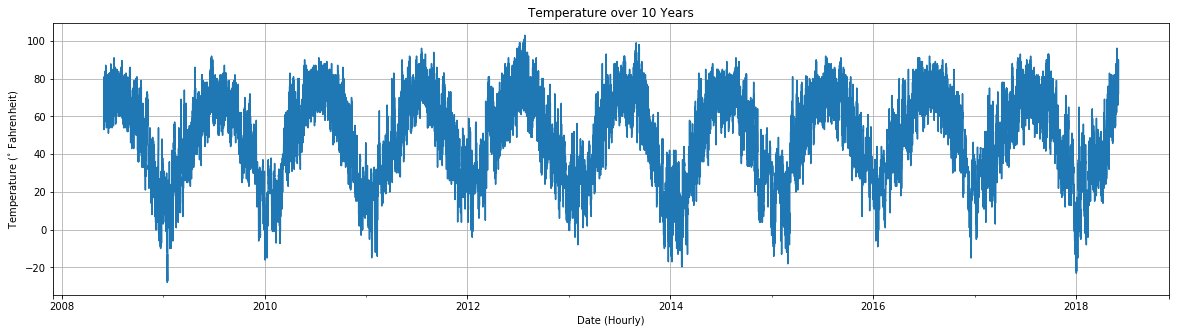

In [14]:
fig, ax = plt.subplots()
ax = temp_df.tmpf.plot(ax = ax, figsize = (20, 5), grid = True)
ax.set_title('Temperature over 10 Years')
ax.set_xlabel('Date (Hourly)');
ax.set_ylabel('Temperature ($^{\circ}$ Fahrenheit)');

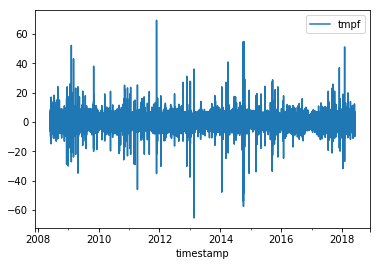

In [15]:
temp_df.diff(periods = 1).diff(periods = 1).dropna().plot()

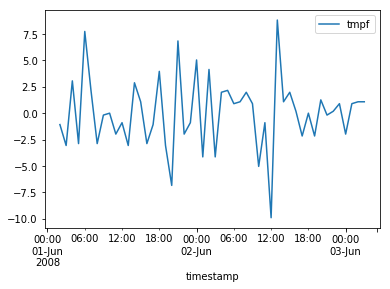

In [16]:
temp_df.diff(periods = 1).diff(periods = 1).dropna()[:50].plot()

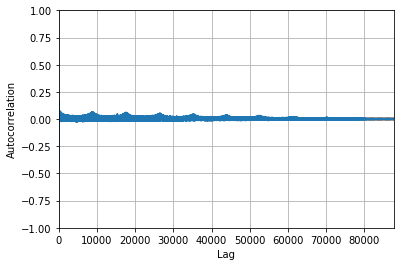

In [17]:
ax = autocorrelation_plot(temp_df.diff(periods = 1).diff(periods = 1).dropna());

In [18]:
from statsmodels.tsa.stattools import adfuller

def TestStationaryPlot(ts, window = 1):
    rol_mean = ts.rolling(window = window, center = False).mean()
    rol_std = ts.rolling(window = window, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    
    plt.xlabel('Date')
    plt.ylabel('Temperature ($^{\circ} Fahrenheit)')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0: 4], index = ['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
    
    for key, value in ts_test[4].items():
        ts_test_output['Critical Value (%s)' % key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


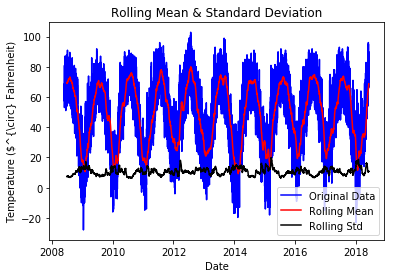

In [585]:
TestStationaryPlot(temp_df.tmpf, window = 24 * 30)

In [587]:
TestStationaryAdfuller(temp_df.tmpf)

Test Statistic                -7.351742e+00
p-value                        1.001807e-10
#Lags Used                     6.600000e+01
Number of Observations Used    8.760600e+04
Critical Value (1%)           -3.430425e+00
Critical Value (5%)           -2.861573e+00
Critical Value (10%)          -2.566788e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


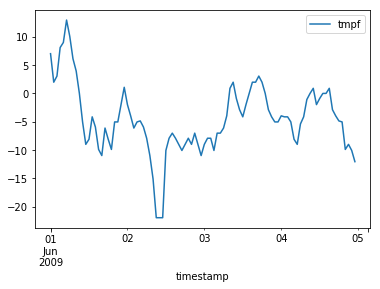

In [617]:
temp_df.diff(24 * 365).dropna()[:4*24].plot()

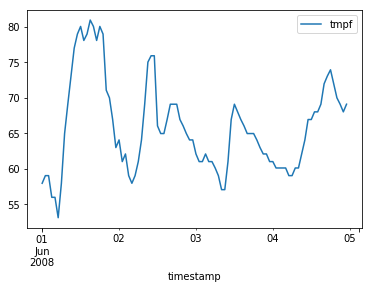

In [616]:
temp_df[:4*24].plot()

In [604]:
temp_df.diff(24).dropna()

720

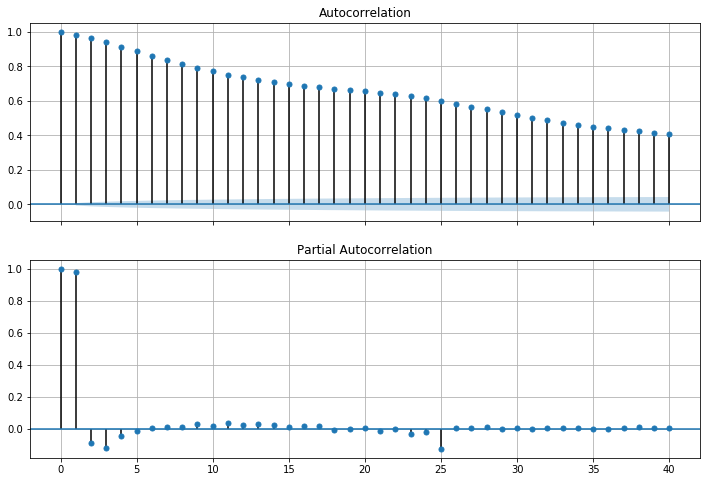

In [24]:
fig, ax = plt.subplots(figsize = (12, 8), nrows = 2, sharex = True)
sm.graphics.tsa.plot_acf(temp_df.diff(24 * 365).dropna(), lags = 40, ax = ax[0]);
sm.graphics.tsa.plot_pacf(temp_df.diff(24 * 365).dropna(), lags = 40, ax = ax[1]);
for x in ax:
    x.grid()

In [26]:
import itertools
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)


In [28]:
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(temp_df.diff(24 * 365).dropna(),
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will 

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq,

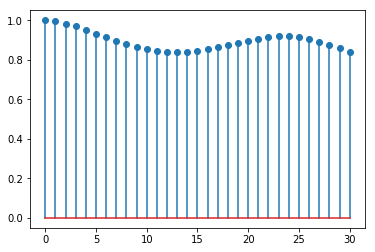

In [531]:
from statsmodels.tsa.stattools import acf, pacf
plt.stem(acf(temp_df, nlags = 30));

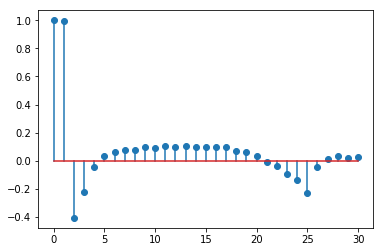

In [530]:
plt.stem(pacf(temp_df, nlags = 30));

In [ ]:
date = np.random.choice(dates)

train, test = temp_df[temp_df.index.date < date], temp_df[temp_df.index.date == date]
model = SARIMAX(train, order = (0, 0, 0), seasonal_order = (0, 1, 0, 24)).fit(disp = False)

temp_df[temp_df.index.date <= date][-200:].plot()
model.forecast(len(test)).plot()

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [563]:
model = ARIMA(temp_df.tmpf, order = (1, 1, 0), freq = 'H')
model_fit = model.fit(disp = 0)

/usr/local/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

In [366]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.tmpf   No. Observations:                87672
Model:                 ARIMA(1, 1, 0)   Log Likelihood             -193807.032
Method:                       css-mle   S.D. of innovations              2.207
Date:                Sat, 10 Nov 2018   AIC                         387620.063
Time:                        23:49:20   BIC                         387648.207
Sample:                    06-01-2008   HQIC                        387628.655
                         - 06-02-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.012      0.012      0.990      -0.024       0.025
ar.L1.D.tmpf     0.4017      0.003    129.866      0.000       0.396       0.408
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.4897           +0.0000j            2.4897            0.0000
-----------------------------------------------------------------------------
"""